In [1]:
import coolingFunction

In [2]:
import copy
import numpy as np
import h5py
import scipy
import scipy.special
import sys
import verdict
import os
import tqdm
import unyt

In [3]:
import kalepy as kale

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
import matplotlib.cm as cm
import matplotlib.colors as plt_colors
import matplotlib.gridspec as gridspec
import matplotlib.transforms
import palettable

In [5]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as worldline_set
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [6]:
import galaxy_dive.analyze_data.ahf as analyze_ahf
import galaxy_dive.plot_data.ahf as plot_ahf
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.executable_helpers as exec_helpers

In [7]:
import linefinder.utils.file_management as file_management
import linefinder.config as config

In [8]:
import trove

# Load Data

In [9]:
pm = dict(
    snum = 600,
    tables_dir = '/work/03057/zhafen/CoolingTables/',
    study_duplicates = False,
    ahf_index = 600,
)

In [10]:
pm = trove.link_params_to_config(
    '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
    variation = 'm12i_md',
    **pm
)

In [11]:
# Used so often it's nice to not enclose
snum = pm['snum']
ind = pm['ahf_index'] - snum

In [12]:
w = a_worldlines.Worldlines(
    tag = pm['tag'],
    data_dir = pm['data_dir'],
    halo_data_dir = pm['halo_data_dir'],
    ahf_index = pm['ahf_index'],
)

In [13]:
w.retrieve_halo_data()

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [14]:
m_plot_label  = r'$M_{\rm h} = 10^{' + '{:.02g}'.format( np.log10( w.m_vir[snum] ) )
m_plot_label += '} M_\odot$'
plot_label = m_plot_label + ', z={:.02}'.format( w.redshift[snum] )
print( plot_label )

$M_{\rm h} = 10^{12} M_\odot$, z=0.0


In [15]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )

In [16]:
w_plotter = p_worldlines.WorldlinesPlotter( w, label=plot_label )

# Data Pre-Processing

## Calculate $\theta$
Also called $\phi$...

In [17]:
tot_momentum_fp = os.path.join( pm['processed_data_dir'], 'tot_momentums.hdf5' )
tot_ang_momentum = verdict.Dict.from_hdf5( tot_momentum_fp )[pm['variation']]['snum{:03d}'.format( snum )]

In [18]:
w.calc_abs_phi( normal_vector=tot_ang_momentum )

## Calculate mass deposition

In [19]:
delta_m = w.get_data( 'M' )[:,:-1] - w.get_data( 'M' )[:,1:]
deposited_m = np.ma.masked_array( delta_m, delta_m<0 ).sum( axis=1 ).data

# Analysis

In [20]:
# Setup axes
t_window = 1.
t = w.get_data( 'time' )
x_range = [ t[ind] - t_window, t[ind] ]

In [21]:
t_snaps = t[( t > x_range[0] ) & ( t < x_range[1] )][::-1]

In [22]:
n_snaps = t_snaps.size

In [23]:
dt = t_snaps[1:] - t_snaps[:-1]

In [24]:
t_bins = np.zeros( ( t_snaps.size + 1, ) )
t_bins[1:-1] = t_snaps[:-1] + dt / 2.
t_bins[0] = t_snaps[0] - dt[0] / 2.
t_bins[-1] = t_snaps[-1] + dt[-1] / 2.

In [25]:
   
w.data_masker.clear_masks()
w.data_masker.mask_data( 'PType', data_value=0 )

# Median and interval stats
logT = np.log10( w.get_selected_data( 'T', compress=False ) )#[:,ind:ind+n_snaps+1]
R = w.get_selected_data( 'R', compress=False )#[:,ind:ind+n_snaps+1]
L = w.get_selected_data( 'Lmag', compress=False )#[:,ind:ind+n_snaps+1]
M = w.get_selected_data( 'M', compress=False )#[:,ind:ind+n_snaps+1]

logT_med = np.nanmedian( logT, axis=0 )
R_med = np.nanmedian( R, axis=0 )

logT_low = np.nanpercentile( logT, 16, axis=0 )
logT_high = np.nanpercentile( logT, 84, axis=0 )

R_low = np.nanpercentile( R, 16, axis=0 )
R_high = np.nanpercentile( R, 84, axis=0 )

inds = w.get_data( 't_1e5_inds' )

R_at_Tcool = np.array( [ R[i, ind] for i, ind in enumerate( inds ) ] )
M_at_Tcool = np.array( [ M[i, ind] for i, ind in enumerate( inds ) ] )
L_at_Tcool = np.array( [ L[i, ind] for i, ind in enumerate( inds ) ] )
R_rgal_at_Tcool = np.array( [ R[i, ind]/w.r_gal[ind] for i, ind in enumerate( inds ) ] )

t_at_Tcool = np.array( [ t[ind] for ind in inds ] )


100%|██████████| 45846/45846 [00:03<00:00, 13435.81it/s]


### Store for Later Use

In [26]:
data_fp = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )

In [27]:
try:
    data = verdict.Dict.from_hdf5( data_fp )
except OSError:
    data = verdict.Dict({})

In [28]:
# Store R for later use
r_vir = w.r_vir[snum]
r_points, r_pdf = kale.density(
    R_at_Tcool[np.invert(np.isnan(R_at_Tcool))],
    points = np.linspace( 0., r_vir, 512 ),
    probability = True,
    reflect = [ 0., None ],
)

In [29]:
data_to_store = {
    'points': r_points,
    'pdf': r_pdf,
    'median': np.nanmedian( R_at_Tcool ),
    '16th_percentile': np.nanpercentile( R_at_Tcool, 16 ),
    '84th_percentile': np.nanpercentile( R_at_Tcool, 84 ),
}

In [30]:
# Store radius for later use
if not 'R1e5K' in data.keys():
    data['R1e5K'] = {}
for key, item in data_to_store.items():
    if key not in data['R1e5K']:
        data['R1e5K'][key] = {}
    data['R1e5K'][key][pm['variation']] = item

In [31]:
# Store R for later use
r_vir = w.r_vir[snum]
r_points, r_pdf = kale.density(
    R_rgal_at_Tcool[np.invert(np.isnan(R_rgal_at_Tcool))],
    points = np.linspace( 0., r_vir / w.r_gal[0], 512 ),
    probability = True,
    reflect = [ 0., None ],
)

In [32]:
data_to_store = {
    'points': r_points,
    'pdf': r_pdf,
    'median': np.nanmedian( R_rgal_at_Tcool ),
    '16th_percentile': np.nanpercentile( R_rgal_at_Tcool, 16 ),
    '84th_percentile': np.nanpercentile( R_rgal_at_Tcool, 84 ),
}

In [33]:
# Store radius relative to galaxy radius for later use
if not 'R1e5K_rgal' in data.keys():
    data['R1e5K_rgal'] = {}
for key, item in data_to_store.items():
    if key not in data['R1e5K_rgal']:
        data['R1e5K_rgal'][key] = {}
    data['R1e5K_rgal'][key][pm['variation']] = item

In [34]:
# Store number of particles tracked
if not 'n_tracked' in data.keys():
    data['n_tracked'] = {}
data['n_tracked'][pm['variation']] = w.n_particles

In [35]:
data.to_hdf5( data_fp )
print( 'Stored summary data at {}'.format( data_fp ) )

Stored summary data at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/data/summary.hdf5


## Accretion Tracks and $R_{\rm 10^5K}$ Distribution

In [36]:
dt_before = -1.
dt_after = 0.5
color_dt = 0.2
n_particles = 5
x_lim = np.array( [ 0, 105 ] )
y_lim = np.array( [ 5e3, 5e6 ] )
y2_lim = np.array( [ 1, 1e2 ] )

Median R_at_Tcool = 0.0599 Rvir


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/tracks/tracks_m12i_md.pdf


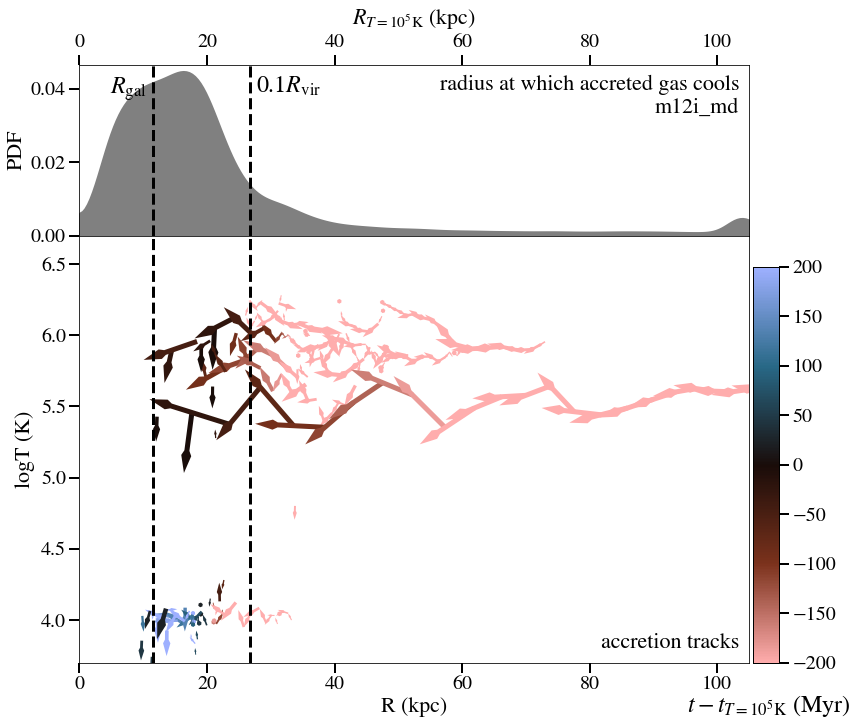

In [37]:
%matplotlib inline

# Load sim data

w.data_masker.clear_masks()

# Only include particles that have never left the main galaxy
w.data_masker.mask_data( 'n_out', -1, 1 )

np.random.seed( 4 )

fig = plt.figure( figsize=(12, 11), facecolor='w' )
ax = plt.gca()

gs = gridspec.GridSpec(7, 1)
gs.update( hspace=0.001 )

ax1 = plt.subplot(gs[:2,0])

r_for_hist = copy.copy( R_at_Tcool )
r_for_hist[r_for_hist>x_lim[1]] = x_lim[1]*.99
bins = np.linspace( x_lim[0], x_lim[1], 256 )
centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

r_points, r_pdf = kale.density(
    r_for_hist[np.invert(np.isnan(r_for_hist))],
    points = centers,
    probability = True,
    reflect = [ 0., None ],
)
ax1.fill_between(
    r_points,
    r_pdf,
    color = '0.5',
    linewidth = 5,
)

# n, bins, patches = ax1.hist(
#     r_for_hist,
#     bins = ,
#     color = '0.5',
#     density = True,
# )

print( 'Median R_at_Tcool = {:.3g} Rvir'.format( np.nanmedian( R_at_Tcool ) / r_vir ) )

# Don't do the below, because it's so far out that it's not visible
# Create plot for volume filling distribution
#     n_rand = int( 1e5 )
#     data_coords = np.random.uniform( -r_vir, r_vir, (3, n_rand ) )
#     data_r = np.sqrt( ( data_coords ** 2. ).sum( axis=0 ) )
#     filtered_data_r = data_r[data_r<r_vir]
#     ax1.hist(
#         filtered_data_r,
#         bins = bins,
#         color = 'k',
#         density = True,
#         histtype = 'step',
#         linewidth = 3,
#         linestyle = '--',
#     )

# ax.axvline(
#     np.median( R_at_Tcool ),
#     color = 'k',
# )

# ax1.axvline(
#     w.r_gal[0],
#     color = 'k',
#     linestyle = '--',
#     linewidth = 3,
# )

ax1.set_xlim( x_lim )
ax1.set_ylim( 0, r_pdf.max()*1.05 )

ax1.set_xlabel( r'$R_{T=10^5{\rm K}}$ (kpc)', fontsize=22, labelpad=10 )
ax1.xaxis.set_label_position( 'top' )
ax1.set_ylabel( 'PDF', fontsize=22, )

ax1.tick_params( axis='x', top=True, labeltop=True, bottom=False, labelbottom=False )
# ax1.tick_params( axis='y', left=False, labelleft=False, )

ax1.annotate(
    s='radius at which accreted gas cools\n{}'.format( pm['variation'] ),
    xy=(1,1),
    xycoords='axes fraction',
    xytext=(-10,-10),
    textcoords='offset points',
    ha = 'right',
    va = 'top',
    fontsize = 22,
)


### FLOW PLOT ####

ax2 = plt.subplot(gs[2:,0])
ax3 = ax

# Choose particles
particle_inds = np.random.choice( np.arange( w.n_particles ), size=n_particles, replace=False )

# Get the time at the phase
t_min_t_cool = ( t[:,np.newaxis] - t[inds] ).transpose()
w.data['t_rel_t1e5'] = t_min_t_cool

# Get positions in r-T space and color
valid_value = ( t_min_t_cool < dt_after ) & ( t_min_t_cool > dt_before )
valid_value = valid_value & ( w.get_data( 'n_out' ) == 0 )
valid_value_inds = valid_value[particle_inds]
r_vecs_all = w.get_data( 'R' )[particle_inds]
T_vecs_all = w.get_data( 'T' )[particle_inds]
K_vecs_all = w.get_data( 'entropy' )[particle_inds]

# Plot quivers for each particles
for k, particle_ind in enumerate( particle_inds ):

    # Format for quiver
    r_vecs = r_vecs_all[k][valid_value_inds[k]]
    T_vecs = np.log10( T_vecs_all[k][valid_value_inds[k]] )
    K_vecs = np.log10( K_vecs_all[k][valid_value_inds[k]] )
    x = r_vecs[1:]
    y = T_vecs[1:]
    y2 = K_vecs[1:]
    dx = r_vecs[:-1] - r_vecs[1:]
    dy = T_vecs[:-1] - T_vecs[1:]
    dy2 = K_vecs[:-1] - K_vecs[1:]
    angles_deg = np.arctan2( dy, dx ) * 180. / np.pi
    C = t_min_t_cool[particle_inds][k,valid_value_inds[k]][1:] * 1e3

    # Plot quiver
    quiver = ax2.quiver(
        x, y,
        dx, dy,
        C,
        angles = 'xy',
        units = 'y',
        scale = 10,
        minshaft = 2,
        headwidth = 2,
        headlength = 3.5,
#             color = 'red',
        cmap = palettable.scientific.diverging.Berlin_5_r.mpl_colormap,
        norm = plt.Normalize( -color_dt*1e3, color_dt*1e3 ),
    )
    plotting.add_colorbar(
        fig,
#             ax2,
        quiver,
        ax_location = [0.905, 0.125, 0.03, 0.5],
#             method = 'ax',
    )

#     w_plotter.plot_streamlines(
#         ax = ax2,
#         x_key = 'R',
#         y_key = 'logT',
#         start_ind = ind,
#         end_ind = 'time_based',
#         t_end = 5.,
#         sample_inds = particle_inds,
#         sample_selected_interval = False,
# #         x_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 7 },
# #         y_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 7 },
#         color = 'black',
#         fade_color = 'black',
#         min_fade_linewidth = 0.5,
#     #     fade_streamlines = False,
#     #     line_features = gas_to_star_line_features,
#         linewidth = 1,
#         x_label = 'R (kpc)',
#         y_label = 'logT (K)',
#     #     y_scale = 'log',
#         x_range = [ 0, 100. ],
#         y_range = [ 3.5, 6.9 ],
#     #     y_floor = 10.**3.8,
#     )

# Plot reference entropy lines
r = w.get_data( 'R' )
at_border = ( r < 1.1 * x_lim[1] ) & ( r > 0.9 * x_lim[1] ) & valid_value
k_at_border = w.get_data( 'entropy' )[at_border]
med_k_at_border = np.nanmedian( k_at_border )
a_vals = [ 0, 1, 2 ]
r_arr = np.linspace( x_lim[0], x_lim[1], 256 )
k_arrs = [ med_k_at_border * ( r_arr / x_lim[1] )**a for a in a_vals ]
for m, k_arr in enumerate( k_arrs ):
    ax3.plot(
        r_arr,
        np.log10( k_arr ),
        color = '0.25',
        linewidth = 1.5,
#             linestyle = '--',
    )
    ax3.annotate(
        s = r'$\propto r^{' + str( a_vals[m] ) + r'}$',
        xy = ( r_arr[100], np.log10( k_arr[100] ) ),
        xycoords = 'data',
        xytext = ( 0, 0 ),
        textcoords = 'offset points',
        ha = 'right',
        va = 'bottom',
        fontsize = 24,
        color = '0.25',
    )

# # Time
# ax.plot(
#     R_med,
#     logT_med,
#     linewidth = 3,
#     color = 'b',
# )
# ax.fill_between(
#     R_med,
#     logT_low,
#     logT_high,
#     color = 'b',
#     alpha = 0.25,
# )

for ax_k in [ ax2, ax3 ]:
    ax_k.annotate(
        s='accretion tracks',
        xy=(1,0),
        xycoords='axes fraction',
        xytext=(-10,10),
        textcoords='offset points',
        ha = 'right',
        va = 'bottom',
        fontsize = 22,
    )

t_label = ax2.annotate(
    s = r'$t - t_{T=10^5 {\rm K}}$ (Myr)',
    xy = ( 1, 0 ),
    xycoords = 'axes fraction',
    xytext = ( 20, -30 ),
    textcoords = 'offset points',
    ha = 'center',
    va = 'top',
    fontsize = 24,
)

# Radius lines
for ax_k in [ ax1, ax2, ax3 ]:
    ax_k.axvline(
        0.1 * r_vir,
        color = 'k',
        linestyle = '--',
        linewidth = 3,
    )
#     ax_k.axvline(
#         r_vir,
#         color = 'k',
#         linestyle = '--',
#         linewidth = 3,
#     )
    ax_k.axvline(
        w.r_gal[ind],
        color = 'k',
        linestyle = '--',
        linewidth = 3,
    )
    if ax_k.is_first_row():
        trans = matplotlib.transforms.blended_transform_factory( ax_k.transData, ax_k.transAxes )
        ax_k.annotate(
            s = r'$0.1 R_{\rm vir}$',
            xy = ( 0.1 * r_vir, 1.0 ),
            xycoords = trans,
            xytext = ( 6, -10 ),
            textcoords = 'offset points',
            ha = 'left',
            va = 'top',
            fontsize = 24,
        )
        ax_k.annotate(
            s = r'$ R_{\rm gal}$',
            xy = ( w.r_gal[ind], 1.0 ),
            xycoords = trans,
            xytext = ( -6, -10 ),
            textcoords = 'offset points',
            ha = 'right',
            va = 'top',
            fontsize = 24,
        )

# Remove bottom ticks on middle axis
#     ax2.tick_params( axis='x', bottom=False, labelbottom=False )

ax2.set_xlim( x_lim )
ax2.set_ylim( np.log10( y_lim ) )
ax2.set_ylabel( '$\log$T (K)', fontsize=22 )
ax3.set_xlim( x_lim )
ax3.set_ylim( np.log10( y2_lim) )
ax2.set_xlabel( 'R (kpc)', fontsize=22 )
ax3.set_ylabel( r'$\log$K (Kev cm$^2$)', fontsize=22 )

plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'tracks' ),
    save_file = 'tracks_{}.pdf'.format( pm['variation'] ),
    fig = fig,
)


## Angular Distribution

In [55]:
bins = np.linspace( -1., 1., 128 )
centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

In [56]:
t_t1e5_centers = np.array([ -0.15, -0.06, -0.03, 0., 0.03, 0.06, 0.15, ])

In [57]:
def calc_sph_harm_moment( l, m, phi, masses, radii ):
    
    prefactor = np.sqrt( 4. * np.pi / (2. * l + 1) )
    ylm = scipy.special.sph_harm( m, l, 0., phi ).real
    to_sum = masses * radii**l * ylm
    
    return prefactor * to_sum.sum()

In [58]:
# Get the time at the phase
t_t1e5 = ( t[:,np.newaxis] - t[inds] ).transpose()
t_t1e5_flat = t_t1e5.flatten()

# Get phi (also known as theta)
w.data_masker.clear_masks()
w.data_masker.mask_data( 'PType', data_value=0 )

phi = w.get_selected_data( 'Phi', compress=False ).flatten()
r_scale = np.full( w.n_snaps, np.nan )
r_scale[:w.r_gal.size] = w.r_gal
radii = ( w.get_selected_data( 'R', compress=False ) / r_scale ).flatten()
masses = w.get_selected_data( 'M', compress=False ).flatten()

# Get distributions
cosphi_dists = []
cosphi_16ths = []
cosphi_84ths = []
cosphi_stds = []
q20 = []
q33 = []
dt = t_t1e5_centers[1] - t_t1e5_centers[0]
for i, center in enumerate( tqdm.tqdm( t_t1e5_centers ) ):
    bin_low = center - dt / 2.
    bin_high = center + dt / 2.
    in_bin = ( t_t1e5_flat > bin_low ) & ( t_t1e5_flat < bin_high )
    
    phi_arr = phi[in_bin]
    phi_arr_rad = phi_arr * np.pi / 180.
    cosphi_arr = np.cos( phi_arr_rad )
    cosphi_points, cosphi_pdf = kale.density(
        cosphi_arr[np.invert(np.isnan(cosphi_arr))],
        points = centers,
        probability = True,
        reflect = [ -1., 1. ],
    )
    cosphi_dists.append( cosphi_pdf )
    
    cosphi_arr_comp = cosphi_arr.compressed()
    cosphi_16ths.append( np.nanpercentile( cosphi_arr_comp, 16 ) )
    cosphi_84ths.append( np.nanpercentile( cosphi_arr_comp, 84. ) )
    cosphi_stds.append( np.nanstd( cosphi_arr_comp ) )
    
    masked = np.invert( radii.mask ) & in_bin
    q20_i = calc_sph_harm_moment(
        2,
        0,
        phi[masked].compressed(),
        masses[masked].compressed(),
        radii[masked].compressed()
    )
    q20.append( q20_i )
    q33_i = calc_sph_harm_moment(
        3,
        3,
        phi[masked].compressed(),
        masses[masked].compressed(),
        radii[masked].compressed()
    )
    q33.append( q33_i )

100%|██████████| 7/7 [00:14<00:00,  1.97s/it]


In [59]:
labeled_is = np.arange( len( t_t1e5_centers ) )

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/ang_dist_evolution/theta_vs_t_m12i_md.pdf


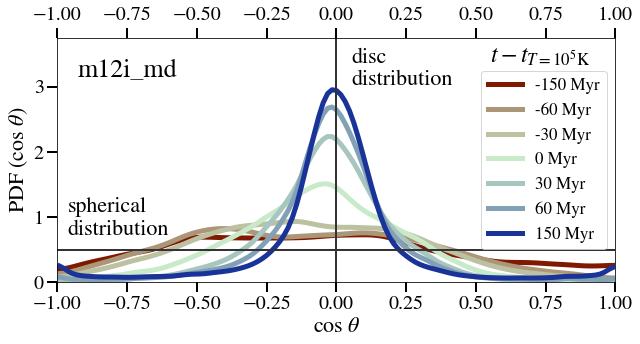

In [60]:
fig = plt.figure( figsize=(10, 4.5 ), facecolor='w' )
ax = plt.gca()

z_max = t_t1e5_centers.max()
z_min = t_t1e5_centers.min()
        
for i, cosphi_dist in enumerate( cosphi_dists ):

    z_width = z_max - z_min
    color_value = ( t_t1e5_centers[i] - z_min )/z_width
    color = palettable.scientific.diverging.Roma_3.mpl_colormap( color_value )

    if i in labeled_is:
        if np.isclose( t_t1e5_centers[i], 0. ):
            t_t1e5_centers[i] = 0
#             label = (
#                 r'$t - t_{T=10^5 {\rm K}}$ =' +
#                 ' {:.3g}'.format( t_tphase_centers[i]*1e3 ) +
#                 r' Myr'
#             )
        label = (
            '{:.3g}'.format( t_t1e5_centers[i]*1e3 ) +
            r' Myr'
        )
    else:
        label = None

    line = ax.plot(
        centers,
        cosphi_dist, #/ (np.pi / 180. / 2. * np.sin( bin_centers * np.pi/180. ) ),
        linewidth = 5,
        color = color,
        label = label,
#             zorder = 10 - i,
    )

ax.tick_params(
    axis = 'x',
    top = True,
    labeltop = ax.is_first_row(),
    bottom = ax.is_last_row(),
    labelbottom = ax.is_last_row(),
)

ax.axhline(
    0.5,
    color = '.2',
    linestyle = '-',
    linewidth = 2,
)
ax.axvline(
    0,
    color = '.2',
    linestyle = '-',
    linewidth = 2,
)

# Sim name label
ax.annotate(
    s = pm['variation'],
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 20, -20 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'top',
    fontsize = 26,
)

# line labels
ax.annotate(
    s = 'spherical\ndistribution',
    xy = ( -1, 0.5 ),
    xycoords = 'data',
    xytext = ( 10, 10 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'bottom',
    fontsize = 22,
)
ax.annotate(
    s = 'disc\ndistribution',
    xy = ( 0, 3.75 ),
    xycoords = 'data',
    xytext = ( 15, -10 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'top',
    fontsize = 22,
)

t_label = ax.annotate(
    s = r'$t - t_{T=10^5 {\rm K}}$',
    xy = ( 1, 0.875 ),
    xycoords = 'axes fraction',
    xytext = ( -25, 0 ),
    textcoords = 'offset points',
    ha = 'right',
    va = 'bottom',
    fontsize = 24,
)
t_label.set_zorder( 1000 )
ax.legend(
    prop={'size': 17},
    loc = 'center right',
)

ax.set_xlim( -1, 1 )
ax.set_ylim( 0, 3.75 )

ax.set_xlabel( r'$\cos\ \theta$', fontsize=22 )
# if ax.is_first_row():
#     ax.xaxis.set_label_position( 'top' )
ax.set_ylabel( r'PDF$\ (\cos\ \theta$)', fontsize=22 )

plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'ang_dist_evolution' ),
    save_file = 'theta_vs_t_{}.pdf'.format( pm['variation'] ),
    fig = fig,
)

### Store phis for later aggregate use

In [61]:
zero_ind = np.argmin( np.abs( centers ) )
pdf_at_zero = np.array( cosphi_dists )[:,zero_ind]

In [62]:
data_to_store = {
    'points': centers,
    't_t1e5_centers': t_t1e5_centers,
    'pdf': np.array( cosphi_dists ),
    '16th_percentile': cosphi_16ths,
    '84th_percentile': cosphi_84ths,
    'std': cosphi_stds,
    'pdf(cos theta=0)': pdf_at_zero,
    'q20': q20,
    'q33': q33,
}

In [63]:
# Store circularity for later use
if not 'cosphi' in data.keys():
    data['cosphi'] = {}
for key, item in data_to_store.items():
    if key not in data['cosphi']:
        data['cosphi'][key] = {}
    data['cosphi'][key][pm['variation']] = item
data.to_hdf5( data_fp )
print( 'Stored summary data at {}'.format( data_fp ) )

Stored summary data at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/data/summary.hdf5


### Estimate Quiet Accretion Fraction

(-1, 1)

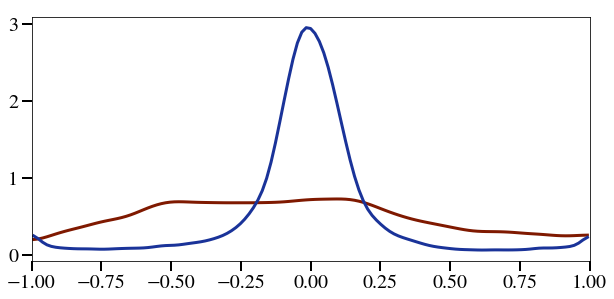

In [65]:
fig = plt.figure( figsize=(10, 4.5 ), facecolor='w' )
ax = plt.gca()

for i in [ 0, -1 ]:
    
    ax.plot(
        centers,
        cosphi_dists[i],
        color = palettable.scientific.diverging.Roma_3.mpl_colors[i],
        linewidth = 3,
    )
    
ax.set_xlim( -1, 1 )

## Orbit Distribution

In [47]:
h_param = w.ptracks.data_attrs['hubble']
snums = w.get_data( 'snum' )
redshifts = w.get_data( 'redshift' )

In [48]:
jz = []
jmag = []
jcirc = []
for i, snum_i in tqdm.tqdm( enumerate( snums ) ):

    def get_M_enc( r ):
        r_ckpc = r / ( h_param * ( 1. + redshifts[i] ) )
        M_enc = w.halo_data.get_profile_data(
            'M_in_r',
            snum_i,
            r_ckpc
        ) / h_param
        M_enc[np.isnan(M_enc)] = 0.
        M_enc[np.arange(M_enc.size)>np.argmax(M_enc)] = M_enc.max()
        return M_enc

    # masses enclosed
    r_i = w.get_data( 'R' )[:,i]
    r_i[r_i>w.r_vir[snum_i]] = np.nan
    try:
        M_enc_i = get_M_enc( r_i )
    except ( KeyError, NameError, TypeError, IndexError ) as e:
        jz.append( np.full( r_i.shape, np.nan ) )
        jmag.append( np.full( r_i.shape, np.nan ) )
        jcirc.append( np.full( r_i.shape, np.nan ) )
        continue

    # Get grid masses enclose
    r_grid = np.linspace( 0.00001, w.r_vir[snum_i], 1024 )
    M_enc_grid = get_M_enc( r_grid )

    # Get potential energy
    pot_grid = unyt.G * scipy.integrate.cumtrapz( M_enc_grid/r_grid**2., r_grid, initial=0 ) * unyt.Msun / unyt.kpc
    pot_grid -= pot_grid[-1]
    pot_grid -= unyt.G * w.m_vir[snum] * unyt.Msun / ( w.r_vir[snum] * unyt.kpc )
    pot_grid = pot_grid.to( 'm**2/s**2' )
    pot_fn = lambda x : scipy.interpolate.interp1d( r_grid, pot_grid )( x ) * unyt.m**2. / unyt.s**2.

    # Get energy for a grid, using virial theorem
    spec_e_grid = pot_grid + 0.5 * unyt.G * M_enc_grid * unyt.Msun / ( r_grid * unyt.kpc )

    # Star potential energy, specific energy
    pot_i = pot_fn( r_i )
    v_i = w.get_data( 'Vmag' )[:,i] * unyt.km / unyt.s
    spec_e_i =  pot_i +  0.5 * v_i**2.
    
    # Cap specific energy
    spec_e_i[spec_e_i>spec_e_grid.max()] = np.nan

    # What radii particles would be at if they were circular with the same energy
    r_circ = scipy.interpolate.interp1d( spec_e_grid, r_grid )( spec_e_i )

    # Circular momentum
    M_enc_circ = get_M_enc( r_circ )
    jcirc_i = np.sqrt( unyt.G * M_enc_circ * unyt.Msun * r_circ * unyt.kpc)
    jcirc.append( jcirc_i.to( 'km*kpc/s' ) )

    # Angular momentum
    ang_mom_dir = tot_ang_momentum / np.linalg.norm( tot_ang_momentum )
    l_units = unyt.Msun * unyt.kpc * unyt.km / unyt.s
    lz_i = np.dot( w.get_data( 'L', )[:,:,i].transpose(), ang_mom_dir ) * l_units
    lmag_i = w.get_data( 'Lmag' )[:,i] * l_units
    m_i= w.get_data( 'M' )[:,i] * unyt.Msun
    jz_i = lz_i / m_i
    jmag_i = lmag_i / m_i
    jz.append( jz_i.to( 'km*kpc/s' ) )
    jmag.append( jmag_i.to( 'km*kpc/s' ) )
jz = np.array( jz ).transpose()
jmag = np.array( jmag ).transpose()
jcirc = np.array( jcirc ).transpose()

601it [06:09,  1.62it/s]


In [49]:
w.data['jz'] = jz
w.data['jmag'] = jmag
w.data['jcirc'] = jcirc

In [50]:
# Get the time at the phase
t_t1e5 = ( t[:,np.newaxis] - t[inds] ).transpose()
t_t1e5_flat = t_t1e5.flatten()

# Get phi (also known as theta)
w.data_masker.clear_masks()
w.data_masker.mask_data( 'PType', data_value=0 )

jz = w.get_selected_data( 'jz', compress=False )
jcirc = w.get_selected_data( 'jcirc', compress=False )
m_flat = w.get_selected_data( 'M', compress=False ).flatten()

# Format data
jz_jcirc_flat = ( jz / jcirc ).flatten()

# Get distributions
jz_jcirc_dists = []
thin_disk_fracs = []
thick_disk_fracs = []
dt = t_t1e5_centers[1] - t_t1e5_centers[0]
for i, center in enumerate( t_t1e5_centers ):
    bin_low = center - dt / 2.
    bin_high = center + dt / 2.
    in_bin = ( t_t1e5_flat > bin_low ) & ( t_t1e5_flat < bin_high )
    jz_jcirc_arr = jz_jcirc_flat[in_bin]
    
    jz_jcirc_points, jz_jcirc_pdf = kale.density(
        jz_jcirc_arr[np.invert(np.isnan(jz_jcirc_arr))].compressed(),
        points = centers,
        probability = True,
        reflect = [ -1., 1. ],
    )
    jz_jcirc_dists.append( jz_jcirc_pdf )
    
    m_bin = m_flat[in_bin]
    thin_disk_fracs.append( m_bin[jz_jcirc_arr>=0.8].sum()/m_bin.sum() )
    thick_disk_fracs.append( m_bin[(jz_jcirc_arr<0.8)&(jz_jcirc_arr>=0.2)].sum()/m_bin.sum() )

In [51]:
labeled_is = np.arange( len( t_t1e5_centers ) )

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/circularity_evolution/circularity_vs_t_m12i_md.pdf


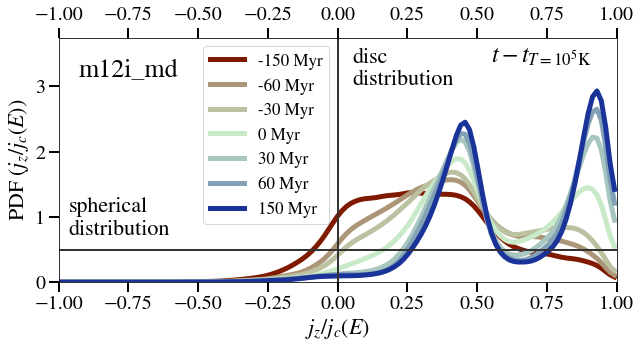

In [52]:
fig = plt.figure( figsize=(10, 4.5 ), facecolor='w' )
ax = plt.gca()

z_max = t_t1e5_centers.max()
z_min = t_t1e5_centers.min()
        
for i, jz_jcirc_dist in enumerate( jz_jcirc_dists ):

    z_width = z_max - z_min
    color_value = ( t_t1e5_centers[i] - z_min )/z_width
    color = palettable.scientific.diverging.Roma_3.mpl_colormap( color_value )

    if i in labeled_is:
        if np.isclose( t_t1e5_centers[i], 0. ):
            t_t1e5_centers[i] = 0
#             label = (
#                 r'$t - t_{T=10^5 {\rm K}}$ =' +
#                 ' {:.3g}'.format( t_tphase_centers[i]*1e3 ) +
#                 r' Myr'
#             )
        label = (
            '{:.3g}'.format( t_t1e5_centers[i]*1e3 ) +
            r' Myr'
        )
    else:
        label = None

    line = ax.plot(
        centers,
        jz_jcirc_dist, #/ (np.pi / 180. / 2. * np.sin( bin_centers * np.pi/180. ) ),
        linewidth = 5,
        color = color,
        label = label,
#             zorder = 10 - i,
    )

ax.tick_params(
    axis = 'x',
    top = True,
    labeltop = ax.is_first_row(),
    bottom = ax.is_last_row(),
    labelbottom = ax.is_last_row(),
)

ax.axhline(
    0.5,
    color = '.2',
    linestyle = '-',
    linewidth = 2,
)
ax.axvline(
    0,
    color = '.2',
    linestyle = '-',
    linewidth = 2,
)

# Sim name label
ax.annotate(
    s = pm['variation'],
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 20, -20 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'top',
    fontsize = 26,
)

# line labels
ax.annotate(
    s = 'spherical\ndistribution',
    xy = ( -1, 0.5 ),
    xycoords = 'data',
    xytext = ( 10, 10 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'bottom',
    fontsize = 22,
)
ax.annotate(
    s = 'disc\ndistribution',
    xy = ( 0, 3.75 ),
    xycoords = 'data',
    xytext = ( 15, -10 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'top',
    fontsize = 22,
)

t_label = ax.annotate(
    s = r'$t - t_{T=10^5 {\rm K}}$',
    xy = ( 1, 0.875 ),
    xycoords = 'axes fraction',
    xytext = ( -25, 0 ),
    textcoords = 'offset points',
    ha = 'right',
    va = 'bottom',
    fontsize = 24,
)
t_label.set_zorder( 1000 )
ax.legend(
    prop={'size': 17},
    loc = 'upper right',
    bbox_to_anchor = ( 0.5, 1. ),
)

ax.set_xlim( -1, 1 )
ax.set_ylim( 0, 3.75 )

ax.set_xlabel( r'$j_z/j_c(E)$', fontsize=22 )
# if ax.is_first_row():
#     ax.xaxis.set_label_position( 'top' )
ax.set_ylabel( r'PDF$\ (j_z/j_c(E)$)', fontsize=22 )

plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'circularity_evolution' ),
    save_file = 'circularity_vs_t_{}.pdf'.format( pm['variation'] ),
    fig = fig,
)

In [53]:
data_to_store = {
    'points': centers,
    't_t1e5_centers': t_t1e5_centers,
    'pdf': np.array( jz_jcirc_dists ),
    'thin_disk_fractions': thin_disk_fracs,
    'thick_disk_fractions': thick_disk_fracs,
}

In [54]:
# Store circularity for later use
if not 'circularity' in data.keys():
    data['circularity'] = {}
for key, item in data_to_store.items():
    if key not in data['circularity']:
        data['circularity'][key] = {}
    data['circularity'][key][pm['variation']] = item
data.to_hdf5( data_fp )
print( 'Stored summary data at {}'.format( data_fp ) )

Stored summary data at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/data/summary.hdf5
